# **SecureAI - Fairness and Bias in AI**


## **Preprocessing bias metigation**

#### This notebook demonstrates the use of an optimized data pre-processing algorithm for bias mitigation in income estimation


**Note**: *This notebook is based on the materials posted in AIF360 github repo*


The goal of this tutorial is to introduce the basic functionality of AI Fairness 360 to an interested developer who may not have a background in bias detection and mitigation.

<br>

____


### Biases and Machine Learning

A machine learning model makes predictions of an outcome for a particular instance. (Given an instance of a loan application, predict if the applicant will repay the loan.) The model makes these predictions based on a training dataset, where many other instances (other loan applications) and actual outcomes (whether they repaid) are provided. Thus, a machine learning algorithm will attempt to find patterns, or generalizations, in the training dataset to use when a prediction for a new instance is needed. (For example, one pattern it might discover is "if a person has salary > USD 40K and has outstanding debt < USD 5, they will repay the loan".) In many domains this technique, called supervised machine learning, has worked very well.

However, sometimes the patterns that are found may not be desirable or may even be illegal. For example, a loan repay model may determine that age plays a significant role in the prediction of repayment because the training dataset happened to have better repayment for one age group than for another. This raises two problems: 1) the training dataset may not be representative of the true population of people of all age groups, and 2) even if it is representative, it is illegal to base any decision on a applicant's age, regardless of whether this is a good prediction based on historical data.

AI Fairness 360 is designed to help address this problem with _fairness metrics_ and _bias mitigators_.  Fairness metrics can be used to check for bias in machine learning workflows.  Bias mitigators can be used to overcome bias in the workflow to produce a more fair outcome.

The loan scenario describes an intuitive example of illegal bias. However, not all undesirable bias in machine learning is illegal it may also exist in more subtle ways.  For example, a loan company may want a diverse portfolio of customers across all income levels, and thus, will deem it undesirable if they are making more loans to high income levels over low income levels.  Although this is not illegal or unethical, it is undesirable for the company's strategy.

As these two examples illustrate, a bias detection and/or mitigation toolkit needs to be tailored to the particular bias of interest.  More specifically, it needs to know the attribute or attributes, called _protected attributes_, that are of interest: race is one example of a _protected attribute_ and age is a second.

<br>

____

## The Machine Learning Workflow
To understand how bias can enter a machine learning model, we first review the basics of how a model is created in a supervised machine learning process.  



![image](https://raw.githubusercontent.com/Trusted-AI/AIF360/e011686ba3d30cd21e04219e502fe33a74ab3817/examples/images/Complex_NoProc_V3.jpg)








First, the process starts with a _training dataset_, which contains a sequence of instances, where each instance has two components: the features and the correct prediction for those features.  Next, a machine learning algorithm is trained on this training dataset to produce a machine learning model.  This generated model can be used to make a prediction when given a new instance.  A second dataset with features and correct predictions, called a _test dataset_, is used to assess the accuracy of the model.
Since this test dataset is the same format as the training dataset, a set of instances of features and prediction pairs, often these two datasets derive from the same initial dataset.  A random partitioning algorithm is used to split the initial dataset into training and test datasets.

Bias can enter the system in any of the `three steps`.  

- The training data set may be biased in that its outcomes may be biased towards particular kinds of instances.  
    
- The algorithm that creates the model may be biased in that it may generate models that are weighted towards particular features in the input.
- The test data set may be biased in that it has expectations on correct answers that may be biased.  

These three points in the machine learning process represent points for testing and mitigating bias.  In AI Fairness 360 codebase, we call these points **_pre-processing_**, **_in-processing_**, and **_post-processing_**.

<br>

____

## AI Fairness 360
We are now ready to utilize AI Fairness 360 (`aif360`) to detect and mitigate bias.  We will use the Adult Census Income dataset, splitting it into a training and test dataset.  We will look for bias in the creation of a machine learning model to predict if an individual's annual income exceeds $50,000 based on various personal attributes.  The protected attribute will be "sex", with "1" (male) and "0" (female) being the values for the privileged and unprivileged groups, respectively.
For this first tutorial, we will check for bias in the initial training data, mitigate the bias, and recheck.  More sophisticated machine learning workflows are given in the author tutorials and demo notebooks in the codebase.

**Here are the steps involved**
- The debiasing function used is implemented in the `OptimPreproc` class.
- Define parameters for optimized pre-processing specific to the dataset.
- Divide the dataset into training, validation, and testing partitions.
- Learn the optimized pre-processing transformation from the training data.
- Train classifier on original training data.
- Estimate the optimal classification threshold, that maximizes balanced accuracy without fairness constraints (from the original validation set).
- Determine the prediction scores for original testing data. Using the estimated optimal classification threshold, compute accuracy and fairness metrics.
- Transform the testing set using the learned probabilistic transformation.
- Determine the prediction scores for transformed testing data. Using the estimated optimal classification threshold, compute accuracy and fairness metrics.

## 1. Install and import required packages

As with any Python program, the first step will be to import the necessary packages.  Below we import several components from the aif360 package.  We import a custom version of the AdultDataset with certain features binned, metrics to check for bias, and classes related to the algorithm we will use to mitigate bias. We also import some other non-aif360 useful packages.

In [1]:
!pip install aif360
# !pip install 'aif360[all]'
# !pip install 'aif360[LFR,OptimPreproc]'

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 259.7/259.7 kB 4.2 MB/s eta 0:00:00


In [2]:
%matplotlib inline
# Load all necessary packages
import sys
import os
import pandas as pd
sys.path.append("../")
import numpy as np
from tqdm import tqdm

from aif360.datasets import BinaryLabelDataset
from aif360.datasets import AdultDataset, GermanDataset, CompasDataset
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.metrics import ClassificationMetric
from aif360.metrics.utils import compute_boolean_conditioning_vector
from aif360.algorithms.preprocessing.optim_preproc import OptimPreproc
from aif360.algorithms.preprocessing.optim_preproc_helpers.data_preproc_functions\
            import load_preproc_data_adult, load_preproc_data_german, load_preproc_data_compas
from aif360.algorithms.preprocessing.optim_preproc_helpers.distortion_functions\
            import get_distortion_adult, get_distortion_german, get_distortion_compas
from aif360.algorithms.preprocessing.optim_preproc_helpers.opt_tools import OptTools
# from common_utils import compute_metrics

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

from IPython.display import Markdown, display
import matplotlib.pyplot as plt
from collections import OrderedDict

import warnings
warnings.filterwarnings('ignore')

pip install 'aif360[Reductions]'
pip install 'aif360[Reductions]'
pip install 'aif360[inFairness]'
pip install 'aif360[Reductions]'


In [3]:
def compute_metrics(dataset_true, dataset_pred,
                    unprivileged_groups, privileged_groups,
                    disp=True):
    """
    Compute classification performance and fairness metrics
    using AIF360's ClassificationMetric.

    Parameters
    ----------
    dataset_true : BinaryLabelDataset
        Ground truth dataset (with true labels).
    dataset_pred : BinaryLabelDataset
        Predicted dataset (with model outputs).
    unprivileged_groups : list(dict)
        Groups considered unprivileged (e.g., [{'gender': 0}]).
    privileged_groups : list(dict)
        Groups considered privileged (e.g., [{'gender': 1}]).
    disp : bool
        Whether to print results. Default = True.

    Returns
    -------
    metrics : OrderedDict
        Dictionary of performance and fairness metrics.
    """

    # Initialize AIF360 ClassificationMetric object
    classified_metric_pred = ClassificationMetric(
        dataset_true,
        dataset_pred,
        unprivileged_groups=unprivileged_groups,
        privileged_groups=privileged_groups
    )

    metrics = OrderedDict()

    # ---- Performance metric ----
    # Balanced accuracy: mean of true positive rate (recall) and true negative rate (specificity).
    # Accounts for imbalanced classes better than standard accuracy.
    metrics["Balanced accuracy"] = 0.5 * (
        classified_metric_pred.true_positive_rate() +
        classified_metric_pred.true_negative_rate()
    )

    # ---- Fairness metrics ----
    # Statistical parity difference: difference in positive outcome rates between
    # unprivileged and privileged groups. (0 = fair)
    metrics["Statistical parity difference"] = classified_metric_pred.statistical_parity_difference()

    # Disparate impact: ratio of positive outcome rates between unprivileged
    # and privileged groups. (1 = fair)
    metrics["Disparate impact"] = classified_metric_pred.disparate_impact()

    # Average odds difference: average difference in false positive rates and
    # true positive rates across groups. (0 = fair)
    metrics["Average odds difference"] = classified_metric_pred.average_odds_difference()

    # Equal opportunity difference: difference in true positive rates between
    # groups. (0 = fair)
    metrics["Equal opportunity difference"] = classified_metric_pred.equal_opportunity_difference()

    # Theil index: inequality measure from information theory, capturing
    # overall disparity in prediction errors. (0 = fair)
    metrics["Theil index"] = classified_metric_pred.theil_index()

    # Optionally display all metrics
    if disp:
        for k in metrics:
            print("%s = %.4f" % (k, metrics[k]))

    return metrics


Download the data from the following links, and save them in _aif360/data/raw/adult_ folder

* https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data
* https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test
* https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.names

In [8]:
if not os.path.exists('./adult/'):
    os.mkdir('adult')
!cd /usr/local/lib/python3.12/dist-packages/aif360/data/raw/adult/ && wget https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data && wget https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test && wget https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.names

--2025-09-09 15:17:42--  https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘adult.data’

adult.data              [   <=>              ]   3.79M  7.70MB/s    in 0.5s    

2025-09-09 15:17:43 (7.70 MB/s) - ‘adult.data’ saved [3974305]

--2025-09-09 15:17:43--  https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘adult.test’

adult.test              [   <=>              ]   1.91M  4.57MB/s    in 0.4s    

2025-09-09 15:17:43 (4.57 MB/s) - ‘adult.test’ saved [2003153]

--2025

#### Load dataset and specify options

In [5]:
column_names = ['age', 'workclass', 'fnlwgt', 'education',
            'education-num', 'marital-status', 'occupation', 'relationship',
            'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week',
            'native-country', 'income-per-year']

na_values = [' ?']

train_path = "./adult/adult.data"
test_path = "./adult/adult.test"

train = pd.read_csv(train_path, header=None, names=column_names,
                skipinitialspace=True, na_values=na_values)
test = pd.read_csv(test_path, header=0, names=column_names,
    skipinitialspace=True, na_values=na_values)

train.head(10)

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income-per-year
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
5,37,Private,284582,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,<=50K
6,49,Private,160187,9th,5,Married-spouse-absent,Other-service,Not-in-family,Black,Female,0,0,16,Jamaica,<=50K
7,52,Self-emp-not-inc,209642,HS-grad,9,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,45,United-States,>50K
8,31,Private,45781,Masters,14,Never-married,Prof-specialty,Not-in-family,White,Female,14084,0,50,United-States,>50K
9,42,Private,159449,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,5178,0,40,United-States,>50K


In [6]:
test.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income-per-year
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K.
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K.
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K.
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K.
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K.


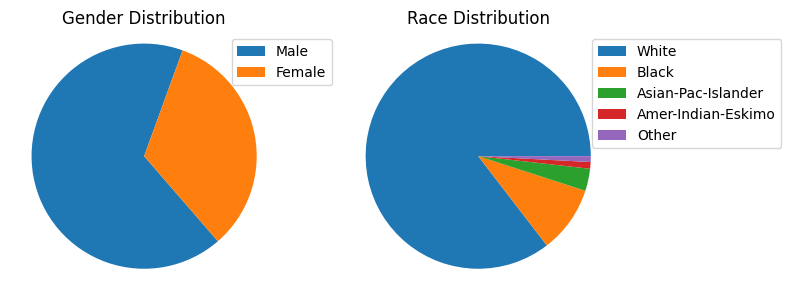

In [12]:
# Calculate the distribution of sex and race
gender_counts = train['sex'].value_counts()
gender_labels = gender_counts.index
gender_sizes = gender_counts.values

race_counts = train['race'].value_counts()
race_labels = race_counts.index
race_sizes = race_counts.values

plt.figure(figsize=(8, 3))

plt.subplot(1, 2, 1)
plt.pie(gender_sizes,  startangle=70)
plt.legend(gender_labels, loc ="upper left", bbox_to_anchor=(0.8, 1))
plt.title('Gender Distribution')
plt.axis('equal')

plt.subplot(1, 2, 2)
plt.pie(race_sizes,  startangle=0)
plt.legend(race_labels, loc ="upper left", bbox_to_anchor=(0.9, 1))
plt.title('Race Distribution')
plt.axis('equal')

plt.tight_layout()
plt.show()

In [9]:
# import dataset
dataset_used = "adult" # "adult", "german", "compas"
protected_attribute_used = 1 # 1, 2

if dataset_used == "adult":
    if protected_attribute_used == 1:
        privileged_groups = [{'sex': 1}]
        unprivileged_groups = [{'sex': 0}]
        dataset_orig = load_preproc_data_adult(['sex'])
    else:
        privileged_groups = [{'race': 1}]
        unprivileged_groups = [{'race': 0}]
        dataset_orig = load_preproc_data_adult(['race'])
    """
    Optimized preprocessing is a preprocessing technique that learns a
    probabilistic transformation that edits the features and labels in the data
    with group fairness, individual distortion, and data fidelity constraints
    and objectives [3]_.

    References:
        .. [3] F. P. Calmon, D. Wei, B. Vinzamuri, K. Natesan Ramamurthy, and
           K. R. Varshney. "Optimized Pre-Processing for Discrimination
           Prevention." Conference on Neural Information Processing Systems,
           2017.
    Paper: https://papers.nips.cc/paper_files/paper/2017/hash/9a49a25d845a483fae4be7e341368e36-Abstract.html
    Based on code available at: https://github.com/fair-preprocessing/nips2017


    For more about the epsilon, clist, and dlist parameters, see the paper.
    See this notebook for details. https://github.com/fair-preprocessing/nips2017/blob/master/Adult/code/Generate_Adult_Data.ipynb

    distortion_fun: Specifies a function that calculates the "distortion" or cost of modifying the dataset to achieve fairness.

    epsilon: Controls the trade-off between fairness and accuracy.
    A smaller epsilon prioritizes fairness, while a larger epsilon allows for more accuracy at the cost of fairness.

    clist: A list of coefficients that define the fairness constraints.
    These values are used to adjust the strength of the fairness constraints during optimization.
    0.99: A lower value may apply a weaker fairness constraint, meaning the model is
    allowed more freedom in making predictions without a strict fairness requirement.
    1.99 and 2.99: Higher values would make the fairness constraint more stringent. As the value increases,
    the model might be forced to adjust predictions or data more significantly to achieve fairness, potentially at the cost of overall accuracy.

    dlist: distortion level, a list of values that control the relaxation of fairness constraints.
    These values allow the algorithm to slightly violate fairness constraints to improve accuracy.
    A value of 0 means no relaxation (strict fairness), while higher values allow more flexibility.

    """
    optim_options = {
        "distortion_fun": get_distortion_adult,
        "epsilon": 0.05,
        "clist": [0.99, 1.99, 2.99],
        "dlist": [.1, 0.05, 0]
    }

elif dataset_used == "german":
    if protected_attribute_used == 1:
        privileged_groups = [{'sex': 1}]
        unprivileged_groups = [{'sex': 0}]
        dataset_orig = load_preproc_data_german(['sex'])
        optim_options = {
            "distortion_fun": get_distortion_german,
            "epsilon": 0.05,
            "clist": [0.99, 1.99, 2.99],
            "dlist": [.1, 0.05, 0]
        }

    else:
        privileged_groups = [{'age': 1}]
        unprivileged_groups = [{'age': 0}]
        dataset_orig = load_preproc_data_german(['age'])
        optim_options = {
            "distortion_fun": get_distortion_german,
            "epsilon": 0.1,
            "clist": [0.99, 1.99, 2.99],
            "dlist": [.1, 0.05, 0]
        }

elif dataset_used == "compas":
    if protected_attribute_used == 1:
        privileged_groups = [{'sex': 1}]
        unprivileged_groups = [{'sex': 0}]
        dataset_orig = load_preproc_data_compas(['sex'])
    else:
        privileged_groups = [{'race': 1}]
        unprivileged_groups = [{'race': 0}]
        dataset_orig = load_preproc_data_compas(['race'])

    optim_options = {
        "distortion_fun": get_distortion_compas,
        "epsilon": 0.05,
        "clist": [0.99, 1.99, 2.99],
        "dlist": [.1, 0.05, 0]
    }
# ['Age (decade)', 'Education Years', 'sex', 'race']

### Divide the dataset into training, validation, and testing partitions.

In [10]:
#random seed
np.random.seed(1)

# Split into train, validation, and test
dataset_orig_train, dataset_orig_vt = dataset_orig.split([0.7], shuffle=True)
dataset_orig_valid, dataset_orig_test = dataset_orig_vt.split([0.5], shuffle=True)

#### Display dataset attributes

In [11]:
dataset_orig.metadata

{'label_maps': [{1.0: '>50K', 0.0: '<=50K'}],
 'protected_attribute_maps': [{1.0: 'Male', 0.0: 'Female'}],
 'transformer': 'AdultDataset.__init__',
 'params': {'df':        race  sex  Income Binary  Age (decade)=10  Age (decade)=20  \
  0       0.0  1.0            0.0              0.0              1.0   
  1       1.0  1.0            0.0              0.0              0.0   
  2       1.0  1.0            1.0              0.0              1.0   
  3       0.0  1.0            1.0              0.0              0.0   
  4       1.0  0.0            0.0              1.0              0.0   
  ...     ...  ...            ...              ...              ...   
  48837   1.0  0.0            0.0              0.0              1.0   
  48838   1.0  1.0            1.0              0.0              0.0   
  48839   1.0  0.0            0.0              0.0              0.0   
  48840   1.0  1.0            0.0              0.0              1.0   
  48841   1.0  0.0            1.0              0.0     

In [12]:
# print out some labels, names, etc.
display(Markdown("#### Training Dataset shape"))
print(dataset_orig_train.features.shape)
display(Markdown("#### Favorable and unfavorable labels"))
print(dataset_orig_train.favorable_label, dataset_orig_train.unfavorable_label)
display(Markdown("#### Protected attribute names"))
print(dataset_orig_train.protected_attribute_names)
display(Markdown("#### Privileged and unprivileged protected attribute values"))
print(dataset_orig_train.privileged_protected_attributes,
      dataset_orig_train.unprivileged_protected_attributes)
display(Markdown("#### Dataset feature names"))
print(dataset_orig_train.feature_names)

#### Training Dataset shape

(34189, 18)


#### Favorable and unfavorable labels

1.0 0.0


#### Protected attribute names

['sex']


#### Privileged and unprivileged protected attribute values

[array([1.])] [array([0.])]


#### Dataset feature names

['race', 'sex', 'Age (decade)=10', 'Age (decade)=20', 'Age (decade)=30', 'Age (decade)=40', 'Age (decade)=50', 'Age (decade)=60', 'Age (decade)=>=70', 'Education Years=6', 'Education Years=7', 'Education Years=8', 'Education Years=9', 'Education Years=10', 'Education Years=11', 'Education Years=12', 'Education Years=<6', 'Education Years=>12']


#### Metric for original training data

In [13]:
# Metric for the original dataset
metric_orig_train = BinaryLabelDatasetMetric(dataset_orig_train,
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)
display(Markdown("#### Original training dataset"))
print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_orig_train.mean_difference())

#### Original training dataset

Difference in mean outcomes between unprivileged and privileged groups = -0.190244


#### Train with and transform the original training data


Optimized preprocessing `(OptimPreproc)` is a preprocessing technique that learns a probabilistic transformation that edits the features and labels in the data with group fairness, individual distortion, and data fidelity constraints and objectives.

    References:
           F. P. Calmon, D. Wei, B. Vinzamuri, K. Natesan Ramamurthy, and
           K. R. Varshney. "Optimized Pre-Processing for Discrimination
           Prevention." Conference on Neural Information Processing Systems,
           2017.

    Based on code available at: https://github.com/fair-preprocessing/nips2017

In [18]:
OP = OptimPreproc(OptTools, optim_options,
                  unprivileged_groups = unprivileged_groups,
                  privileged_groups = privileged_groups)

OP = OP.fit(dataset_orig_train) # Compute optimal pre-processing transformation based on distortion constraint.

# Transform training data and align features
dataset_transf_train = OP.transform(dataset_orig_train, transform_Y=True) #Transform the dataset to a new dataset based on the estimated transformation.
dataset_transf_train = dataset_orig_train.align_datasets(dataset_transf_train)

Optimized Preprocessing: Objective converged to 0.010893


#### Metric with the transformed training data

In [19]:
metric_transf_train = BinaryLabelDatasetMetric(dataset_transf_train,
                                         unprivileged_groups=unprivileged_groups,
                                         privileged_groups=privileged_groups)
display(Markdown("#### Transformed training dataset"))
print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_transf_train.mean_difference())

#### Transformed training dataset

Difference in mean outcomes between unprivileged and privileged groups = -0.049462


Optimized preprocessing has reduced the disparity in favorable outcomes between the privileged and unprivileged
groups (training data).

In [20]:
### Testing
assert np.abs(metric_transf_train.mean_difference()) < np.abs(metric_orig_train.mean_difference())

### Load, clean up original test data and compute metric

In [24]:
dataset_orig_test = dataset_transf_train.align_datasets(dataset_orig_test)
display(Markdown("#### Testing Dataset shape"))
print(dataset_orig_test.features.shape)

metric_orig_test = BinaryLabelDatasetMetric(dataset_orig_test,
                                         unprivileged_groups=unprivileged_groups,
                                         privileged_groups=privileged_groups)
display(Markdown("#### Original test dataset"))
print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_orig_test.mean_difference())

#### Testing Dataset shape

(7327, 18)


#### Original test dataset

Difference in mean outcomes between unprivileged and privileged groups = -0.190984


#### Transform test data and compute metric

In [25]:
dataset_transf_test = OP.transform(dataset_orig_test, transform_Y = True)
dataset_transf_test = dataset_orig_test.align_datasets(dataset_transf_test)

metric_transf_test = BinaryLabelDatasetMetric(dataset_transf_test,
                                         unprivileged_groups=unprivileged_groups,
                                         privileged_groups=privileged_groups)
display(Markdown("#### Transformed test dataset"))
print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_transf_test.mean_difference())

#### Transformed test dataset

Difference in mean outcomes between unprivileged and privileged groups = -0.053044


Optimized preprocessing has reduced the disparity in favorable outcomes between the privileged and unprivileged
groups (test data).

In [26]:
### Testing
assert np.abs(metric_transf_test.mean_difference()) < np.abs(metric_orig_test.mean_difference())

### Train classifier on original data

In [27]:
# Logistic regression classifier and predictions
scale_orig = StandardScaler()
X_train = scale_orig.fit_transform(dataset_orig_train.features)
y_train = dataset_orig_train.labels.ravel()

lmod = LogisticRegression()
lmod.fit(X_train, y_train)
y_train_pred = lmod.predict(X_train)

# positive class index
pos_ind = np.where(lmod.classes_ == dataset_orig_train.favorable_label)[0][0]

dataset_orig_train_pred = dataset_orig_train.copy()
dataset_orig_train_pred.labels = y_train_pred

#### Obtain scores original test set

In [30]:
dataset_orig_valid_pred = dataset_orig_valid.copy(deepcopy=True)
X_valid = scale_orig.transform(dataset_orig_valid_pred.features)
y_valid = dataset_orig_valid_pred.labels
dataset_orig_valid_pred.scores = lmod.predict_proba(X_valid)[:,pos_ind].reshape(-1,1)

dataset_orig_test_pred = dataset_orig_test.copy(deepcopy=True)
X_test = scale_orig.transform(dataset_orig_test_pred.features)
y_test = dataset_orig_test_pred.labels
dataset_orig_test_pred.scores = lmod.predict_proba(X_test)[:,pos_ind].reshape(-1,1)

### Find the optimal classification threshold from the validation set

In [33]:
num_thresh = 100
ba_arr = np.zeros(num_thresh)
class_thresh_arr = np.linspace(0.01, 0.99, num_thresh)
for idx, class_thresh in enumerate(class_thresh_arr):

    fav_inds = dataset_orig_valid_pred.scores > class_thresh
    dataset_orig_valid_pred.labels[fav_inds] = dataset_orig_valid_pred.favorable_label
    dataset_orig_valid_pred.labels[~fav_inds] = dataset_orig_valid_pred.unfavorable_label

    classified_metric_orig_valid = ClassificationMetric(dataset_orig_valid,
                                             dataset_orig_valid_pred,
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)

    ba_arr[idx] = 0.5*(classified_metric_orig_valid.true_positive_rate()\
                       +classified_metric_orig_valid.true_negative_rate())

best_ind = np.where(ba_arr == np.max(ba_arr))[0][0]
best_class_thresh = class_thresh_arr[best_ind]

print("Best balanced accuracy (no fairness constraints) = %.4f" % np.max(ba_arr))
print("Optimal classification threshold (no fairness constraints) = %.4f" % best_class_thresh)

Best balanced accuracy (no fairness constraints) = 0.7463
Optimal classification threshold (no fairness constraints) = 0.2872


In [34]:
display(Markdown("#### Predictions from original testing data"))

bal_acc_arr_orig = []
disp_imp_arr_orig = []
avg_odds_diff_arr_orig = []

display(Markdown("#### Testing set"))
display(Markdown("##### Raw predictions - No fairness constraints"))

for thresh in tqdm(class_thresh_arr):

    fav_inds = dataset_orig_test_pred.scores > thresh
    dataset_orig_test_pred.labels[fav_inds] = dataset_orig_test_pred.favorable_label
    dataset_orig_test_pred.labels[~fav_inds] = dataset_orig_test_pred.unfavorable_label

    if (thresh == best_class_thresh):
        disp = True
    else:
        disp = False

    metric_test_bef = compute_metrics(dataset_orig_test, dataset_orig_test_pred,
                                       unprivileged_groups, privileged_groups, disp=disp)

    bal_acc_arr_orig.append(metric_test_bef["Balanced accuracy"])
    avg_odds_diff_arr_orig.append(metric_test_bef["Average odds difference"])
    disp_imp_arr_orig.append(metric_test_bef["Disparate impact"])

#### Predictions from original testing data

#### Testing set

##### Raw predictions - No fairness constraints

 57%|█████▋    | 57/100 [00:00<00:00, 185.35it/s]

Balanced accuracy = 0.7437
Statistical parity difference = -0.3580
Disparate impact = 0.2794
Average odds difference = -0.3181
Equal opportunity difference = -0.3769
Theil index = 0.1129


100%|██████████| 100/100 [00:00<00:00, 185.89it/s]


#### **Fairness Metrics**

These metrics quantify fairness in the model's predictions. They compare how outcomes differ between **privileged** (e.g., Male, White) and **unprivileged** (e.g., Female, Non-White) groups in the **Adult dataset**.  

Before diving in, here are some important classification terms that appear in the formulas:

<h3><b>Confusion Matrix</b></h3>

<div style="display: flex;">
  <span style="margin-right: 10px;">
    <img src="https://miro.medium.com/v2/resize:fit:640/format:webp/1*-hnHerS0oitp3X0yEjgCHw.png" alt="Sample Image 1" width="300">
  </span>
  <span>
    <img src="https://miro.medium.com/v2/resize:fit:1100/format:webp/1*TAgP-j_02dPpfRiL0fbP-Q.png" alt="Sample Image 2" width="350">
  </span>
</div>

- **True Positives (TP):** Cases where the model correctly predicts high income (>50K).  
- **False Positives (FP):** Cases where the model predicts high income, but the person actually earns ≤50K.  
- **True Negatives (TN):** Cases where the model correctly predicts ≤50K.  
- **False Negatives (FN):** Cases where the model predicts ≤50K, but the person actually earns >50K.  

From these:


<h3><b>Equal opportunity (true positive rate)</b></h3>
<div style="display: flex;">
  <span style="margin-right: 10px;">
    <img src="https://miro.medium.com/v2/resize:fit:1100/format:webp/1*tkiWVGD5nP77eb1cOO5diw.png" alt="Sample Image 1" width="300">
  </span>
  <span>
    <img src="https://miro.medium.com/v2/resize:fit:786/format:webp/1*b6pkia8si4MPMMY0Yx1jUw.png" alt="Sample Image 2" width="300">
  </span>
</div>
<h3><b>False Negative Rate</b></h3>
<div style="display: flex;">
  <span style="margin-right: 10px;">
    <img src="https://miro.medium.com/v2/resize:fit:1100/format:webp/1*6f3Gn0l0mg3QEkdbck_4ng.png" alt="Sample Image 1" width="300">
  </span>
  <span>
    <img src="https://miro.medium.com/v2/resize:fit:786/format:webp/1*RSjLpyS5WDALaLpnIRXwCg.png" alt="Sample Image 2" width="300">
  </span>
</div>

Source: <a href="https://towardsdatascience.com/analysing-fairness-in-machine-learning-with-python-96a9ab0d0705">Link</a>

- **Sensitivity (True Positive Rate, TPR):**  
  $$
  \text{TPR} = \frac{TP}{TP + FN}
  $$  
  Proportion of actual high-income individuals correctly identified.  

- **Specificity (True Negative Rate, TNR):**  
  $$
  \text{TNR} = \frac{TN}{TN + FP}
  $$  
  Proportion of actual low-income individuals correctly identified.  

- **False Positive Rate (FPR):**  
  $$
  \text{FPR} = \frac{FP}{FP + TN}
  $$  
  Proportion of low-income individuals wrongly labeled as high income.  

---

**Balanced Accuracy**

- **Definition**: Average of sensitivity (TPR) and specificity (TNR). Helps when classes are imbalanced (Adult dataset has fewer >50K earners).  

  $$
  \text{Balanced Accuracy} = \frac{\text{Sensitivity} + \text{Specificity}}{2}
  $$

- **Interpretation**: A value of **0.7437** means the model is reasonably accurate across both income groups, not just the majority (≤50K).

---

**Statistical Parity Difference (SPD)**

- **Definition**: Difference in probability of receiving a favorable prediction between unprivileged and privileged groups.  

  $$
  \text{SPD} = P(\hat{Y}=1 \mid \text{unprivileged}) - P(\hat{Y}=1 \mid \text{privileged})
  $$

- **$P(\hat{Y}=1 \mid \text{unprivileged})$**: Probability that the model predicts a *favorable outcome* (e.g., income >50K) for someone in the unprivileged group.  
- **$P(\hat{Y}=1 \mid \text{privileged})$**: Same probability, but for the privileged group.  

- **SPD = 0** → Both groups treated equally.  
- **SPD < 0** → Unprivileged group is *less likely* to get the favorable outcome.  
- **SPD > 0** → Unprivileged group is *more likely*.  


- **Interpretation**: **-0.3580** → unprivileged group is **35.8% less likely** to be predicted as high income.  
  - **Ideal Value**: 0 (both groups equally likely).  
  - SPD shows how much more (or less) likely the unprivileged group is to get a positive outcome compared to the privileged group.  
---

**Disparate Impact (DI)**

- **Definition**: Ratio of favorable outcome rates between unprivileged and privileged groups.  

  $$
  \text{DI} = \frac{P(\hat{Y}=1 \mid \text{unprivileged})}{P(\hat{Y}=1 \mid \text{privileged})}
  $$


This uses the same probabilities as SPD but forms a **ratio** instead of a difference.  

- **DI = 1** → Perfect fairness (equal rates).  
- **DI < 1** → Unprivileged group gets fewer favorable outcomes.  
- **DI > 1** → Unprivileged group gets more favorable outcomes.

- **Interpretation**: **0.2794** → unprivileged group is only **27.94% as likely** to get a positive prediction.  
  - **Ideal Value**: 1 (perfect fairness).  
  - Below 0.8 → often flagged as unfair (the “80% rule”).  
  - DI asks: *What fraction of the privileged group’s positive prediction rate does the unprivileged group get?*  

---

**Average Odds Difference (AOD)**

- **Definition**: Average of the differences in **false positive rates (FPR)** and **true positive rates (TPR)** between groups.  

  $$
  \text{AOD} = \frac{(\text{FPR}_{\text{unprivileged}} - \text{FPR}_{\text{privileged}}) + (\text{TPR}_{\text{unprivileged}} - \text{TPR}_{\text{privileged}})}{2}
  $$

- **Interpretation**: **-0.3181** → unprivileged individuals are both less likely to be correctly identified when they truly earn >50K (lower TPR) **and/or** more likely to be misclassified when they don’t (higher FPR).  
  - **Ideal Value**: 0 (both groups have equal error behavior).  

---

**Equal Opportunity Difference (EOD)**

- **Definition**: Difference in **true positive rates (TPR)** between unprivileged and privileged groups.  

  $$
  \text{EOD} = \text{TPR}_{\text{unprivileged}} - \text{TPR}_{\text{privileged}}
  $$

- **Interpretation**: **-0.3769** → unprivileged individuals who truly earn >50K are **37.69% less likely** to be correctly recognized.  
  - Focuses only on fairness in *positive outcomes*.  
  - **Ideal Value**: 0.  

---

**Theil Index**

- **Definition**: A general inequality measure adapted from economics. It looks at the distribution of predicted outcomes across individuals — if some groups are disproportionately burdened with errors, the index rises.  
  - Related to entropy: higher values mean more inequality.  
  - [Theil Index on Wikipedia](https://en.wikipedia.org/wiki/Theil_index)  

- **Interpretation**: **0.1129** → there is measurable inequality in the predictions, even beyond just group-level fairness.  
  - **Ideal Value**: 0.  

---

**Summary**  
- **Balanced Accuracy** → overall model reliability (performance metric).  
- **SPD, DI, AOD, EOD** → compare fairness across privileged vs unprivileged groups.  
- **Theil Index** → captures broader inequality across the dataset.


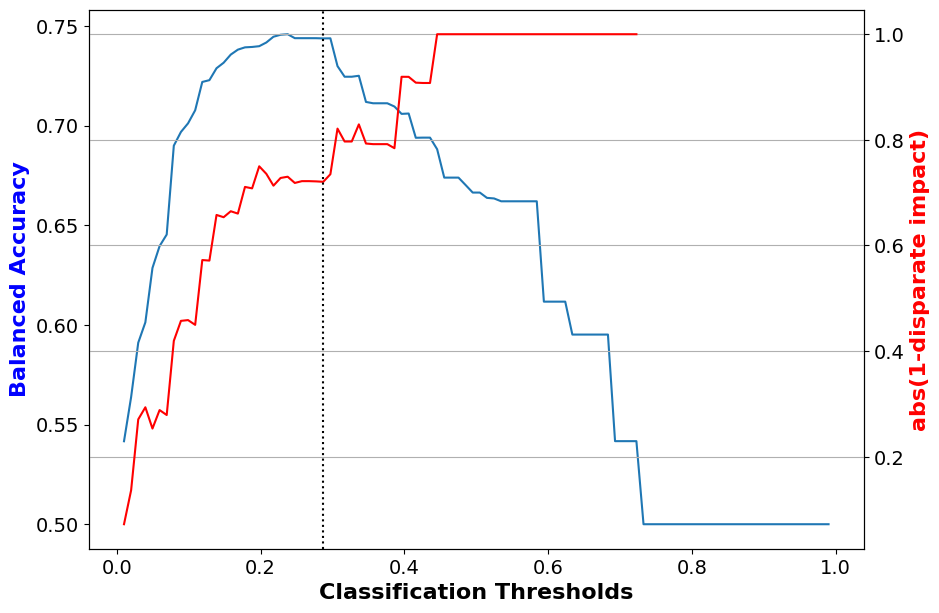

In [35]:
fig, ax1 = plt.subplots(figsize=(10,7))
ax1.plot(class_thresh_arr, bal_acc_arr_orig)
ax1.set_xlabel('Classification Thresholds', fontsize=16, fontweight='bold')
ax1.set_ylabel('Balanced Accuracy', color='b', fontsize=16, fontweight='bold')
ax1.xaxis.set_tick_params(labelsize=14)
ax1.yaxis.set_tick_params(labelsize=14)


ax2 = ax1.twinx()
ax2.plot(class_thresh_arr, np.abs(1.0-np.array(disp_imp_arr_orig)), color='r')
ax2.set_ylabel('abs(1-disparate impact)', color='r', fontsize=16, fontweight='bold')
ax2.axvline(np.array(class_thresh_arr)[best_ind],
            color='k', linestyle=':')
ax2.yaxis.set_tick_params(labelsize=14)
ax2.grid(True)

disp_imp_at_best_bal_acc_orig = np.abs(1.0-np.array(disp_imp_arr_orig))[best_ind]

`abs(1 - Disparate Impact)` must be close to zero for classifier predictions to be fair.

---

### **Relationship Between Balanced Accuracy and `abs(1 - Disparate Impact)`**

When using the **Adult dataset** from AIF360, we’re typically predicting whether an individual earns more than \$50K annually.  
Sensitive attributes often studied are:
- **Sex** (privileged: Male, unprivileged: Female)
- **Race** (privileged: White, unprivileged: Non-white)

Fairness metrics help us see if our classifier treats these groups equitably.

---

#### 1. **Balanced Accuracy**

**Definition**: Balanced accuracy is the average of sensitivity (true positive rate) and specificity (true negative rate).  
It is particularly useful because the Adult dataset is imbalanced (fewer people earn >50K than ≤50K).  

$$
\text{Balanced Accuracy} = \frac{\text{Sensitivity} + \text{Specificity}}{2}
$$

- **Sensitivity (TPR)**: Proportion of high-income individuals correctly identified.  
- **Specificity (TNR)**: Proportion of low-income individuals correctly identified.  

**Interpretation**: Higher balanced accuracy means the model is performing well across both income groups, not just predicting the majority class.

---

#### 2. **Disparate Impact**

**Definition**: Disparate impact compares the probability of receiving a favorable prediction (`\hat{Y}=1`, meaning predicted >50K) between the unprivileged and privileged groups.  

$$
\text{Disparate Impact} = \frac{P(\hat{Y}=1 \mid \text{unprivileged})}{P(\hat{Y}=1 \mid \text{privileged})}
$$

- **Ideal Value**: 1 → both groups are equally likely to get a positive outcome.  
- **Adult dataset context**:  
  - If women (unprivileged) are predicted to have high income at **50% the rate** of men (privileged), then disparate impact = 0.5.  
  - This shows bias in the predictions.

---

#### 3. **`abs(1 - Disparate Impact)`**

**Definition**: This measures how far disparate impact is from the fairness ideal (1).  

$$
\lvert 1 - \text{Disparate Impact} \rvert
$$

**Interpretation**:
- **0** → Perfect fairness (disparate impact = 1).  
- Larger values → More unfairness.  
- **Regulatory note**: In U.S. legal contexts, the "80% rule" is often used:  
  - A disparate impact below 0.8 (or above 1.25) is considered evidence of potential discrimination.  
  - That corresponds to `abs(1 - DI) ≥ 0.2`.

---

#### 4. **Relationship Between Performance and Fairness**

There’s often a **trade-off** between accuracy and fairness:

- Increasing **Balanced Accuracy** may worsen fairness (e.g., model becomes very accurate at exploiting biased correlations in the dataset).  
- Improving **fairness** (by adjusting predictions or applying mitigation methods like reweighing, adversarial debiasing, or prejudice remover) can reduce balanced accuracy, since constraints are placed on the model.  

---

#### 5. **Adult Dataset Example**

- **Without mitigation**:  
  - Balanced accuracy may look strong (e.g., ~0.80),  
  - but `abs(1 - DI)` could be large (e.g., ~0.30), showing women are unfairly disadvantaged.  

- **With mitigation (e.g., reweighing)**:  
  - Balanced accuracy may drop slightly (e.g., ~0.76),  
  - but fairness improves (`abs(1 - DI)` closer to 0.05–0.10).  

This illustrates the balance practitioners aim for: **a model that is both accurate and equitable**.

---

#### 6. **Visualization**

To understand the trade-off across thresholds, you can plot:  
- Balanced Accuracy on one axis.  
- `abs(1 - Disparate Impact)` on the other.  

This dual-axis view helps highlight where the model achieves an acceptable balance between predictive power and fairness.


### Train classifier on transformed data and obtain predictions with its fairness metrics

In [36]:
scale_transf = StandardScaler()
X_train = scale_transf.fit_transform(dataset_transf_train.features)
y_train = dataset_transf_train.labels.ravel()

lmod = LogisticRegression()
lmod.fit(X_train, y_train)
y_train_pred = lmod.predict(X_train)

dataset_transf_train_pred = dataset_transf_train.copy()
dataset_transf_train_pred.labels = y_train_pred

### Predictions and fairness metrics from transformed test set

In [37]:
dataset_transf_test_pred = dataset_transf_test.copy(deepcopy=True)
X_test = scale_transf.transform(dataset_transf_test_pred.features)
y_test = dataset_transf_test_pred.labels
dataset_transf_test_pred.scores = lmod.predict_proba(X_test)[:,pos_ind].reshape(-1,1)

In [38]:
display(Markdown("#### Predictions from transformed testing data"))

bal_acc_arr_transf = []
disp_imp_arr_transf = []
avg_odds_diff_arr_transf = []

display(Markdown("#### Testing set"))
display(Markdown("##### Transformed predictions - No fairness constraints"))

for thresh in tqdm(class_thresh_arr):

    fav_inds = dataset_transf_test_pred.scores > thresh
    dataset_transf_test_pred.labels[fav_inds] = dataset_transf_test_pred.favorable_label
    dataset_transf_test_pred.labels[~fav_inds] = dataset_transf_test_pred.unfavorable_label

    if (thresh == best_class_thresh):
        disp = True
    else:
        disp = False

    metric_test_bef = compute_metrics(dataset_transf_test, dataset_transf_test_pred,
                                       unprivileged_groups, privileged_groups, disp=disp)

    bal_acc_arr_transf.append(metric_test_bef["Balanced accuracy"])
    avg_odds_diff_arr_transf.append(metric_test_bef["Average odds difference"])
    disp_imp_arr_transf.append(metric_test_bef["Disparate impact"])

#### Predictions from transformed testing data

#### Testing set

##### Transformed predictions - No fairness constraints

 51%|█████     | 51/100 [00:00<00:00, 123.86it/s]

Balanced accuracy = 0.7081
Statistical parity difference = -0.0781
Disparate impact = 0.7619
Average odds difference = -0.0594
Equal opportunity difference = -0.0653
Theil index = 0.1457


100%|██████████| 100/100 [00:00<00:00, 125.10it/s]


1. **Balanced Accuracy**

    **Without Fairness**: 0.7437 **With Fairness**: 0.7018.

    **Interpretation**: The model without fairness has higher balanced accuracy, indicating better overall performance across both classes. Adding fairness slightly reduces accuracy, as the model prioritizes fairness over pure performance.

2. **Statistical Parity Difference**

    **Without Fairness**: -0.3580 **With Fairness**: -0.0867

    **Interpretation**: The model without fairness shows a large disparity in favorable outcomes between unprivileged and privileged groups. Adding fairness significantly reduces this disparity, making the model more equitable.

3. **Disparate Impact**

    **Without Fairness**: 0.2794 **With Fairness**: 0.7490

    **Interpretation**: Without fairness, the unprivileged group is only 27.94% as likely as the privileged group to receive a favorable outcome. With fairness, this improves to 74.9%, indicating a much fairer distribution of outcomes.

4. **Average Odds Difference**

    **Without Fairness**: -0.3181 **With Fairness**: -0.0678

    **Interpretation**: The model without fairness has a large difference in false positive rates (FPR) and true positive rates (TPR) between groups. Adding fairness reduces this difference, making the model’s predictions more balanced across groups.

5. **Equal Opportunity Difference**

    **Without Fairness**: -0.3769 **With Fairness**: -0.0696

    **Interpretation**: Without fairness, the unprivileged group has a 37.69% lower true positive rate (TPR) compared to the privileged group. With fairness, this gap is reduced to 6.96%, improving equal opportunity for the unprivileged group.

6. **Theil Index**

    **Without Fairness**: 0.1129 **With Fairness**: 0.1476

    **Interpretation**: The model without fairness has a lower Theil index, indicating slightly better equality in outcome distribution. However, this metric alone does not capture the trade-offs between fairness and accuracy.

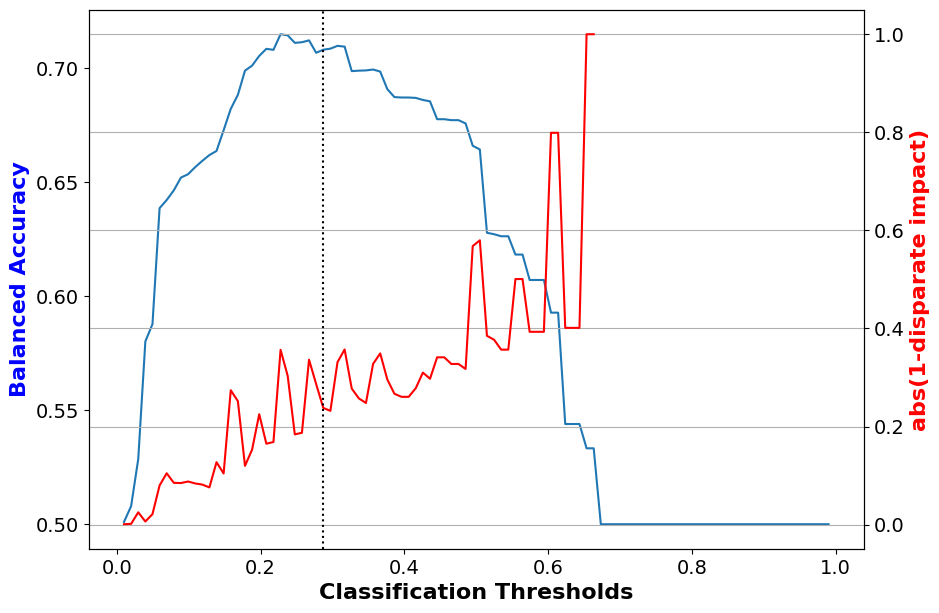

In [39]:
fig, ax1 = plt.subplots(figsize=(10,7))
ax1.plot(class_thresh_arr, bal_acc_arr_transf)
ax1.set_xlabel('Classification Thresholds', fontsize=16, fontweight='bold')
ax1.set_ylabel('Balanced Accuracy', color='b', fontsize=16, fontweight='bold')
ax1.xaxis.set_tick_params(labelsize=14)
ax1.yaxis.set_tick_params(labelsize=14)


ax2 = ax1.twinx()
ax2.plot(class_thresh_arr, np.abs(1.0-np.array(disp_imp_arr_transf)), color='r')
ax2.set_ylabel('abs(1-disparate impact)', color='r', fontsize=16, fontweight='bold')
ax2.axvline(np.array(class_thresh_arr)[best_ind],
            color='k', linestyle=':')
ax2.yaxis.set_tick_params(labelsize=14)
ax2.grid(True)

disp_imp_at_best_bal_acc_transf = np.abs(1.0-np.array(disp_imp_arr_transf))[best_ind]

```abs(1-disparate impact)``` must be close to zero for classifier predictions to be fair. This measure has improved using classifier trained using the transformed data compared to the original data.


In [ ]:
### testing
assert disp_imp_at_best_bal_acc_transf < disp_imp_at_best_bal_acc_orig

# Summary of Results
We show the optimal classification thresholds, and the fairness and accuracy metrics.

### Classification Thresholds

| Dataset |Classification threshold|
|-|-|
|Adult|0.2674|
|German|0.6732|
|Compas|0.5148|

### Fairness Metric: Disparate impact, Accuracy Metric: Balanced accuracy

#### Performance

| Dataset |Sex (Acc-Bef)|Sex (Acc-Aft)|Sex (Fair-Bef)|Sex (Fair-Aft)|Race/Age (Acc-Bef)|Race/Age (Acc-Aft)|Race/Age (Fair-Bef)|Race/Age (Fair-Aft)|
|-|-|-|-|-|-|-|-|-|
|Adult (Test)|0.7417|0.7021|0.2774|0.7729|0.7417|0.7408|0.4423|0.7645|
|German (Test)|0.6524|0.5698|0.9948|1.0664|0.6524|0.6067|0.3824|0.8228|
|Compas (Test)|0.6774|0.6606|0.6631|0.8085|0.6774|0.6790|0.6600|0.8430|
